# Sheet 5

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

# 2) Phase classification in $\phi^4$ theory

(a)

In [2]:
train = np.load("data05/lattice_train.npy")
test = np.load("data05/lattice_test.npy")
kappa = np.arange(0.24, 0.30, 0.0025)

L = 16
lattice_shape = (L,L)

train, test = torch.tensor(train), torch.tensor(test)
symmetric_phase_data, broken_phase_data = train[0,...], train[1,...]

train_data = torch.cat([symmetric_phase_data, broken_phase_data], dim=0)
a = torch.stack((torch.ones(len(symmetric_phase_data),), torch.zeros(len(symmetric_phase_data))), -1)
b = torch.stack((torch.zeros(len(broken_phase_data),), torch.ones(len(broken_phase_data))), -1)
train_labels = torch.cat([a,b])


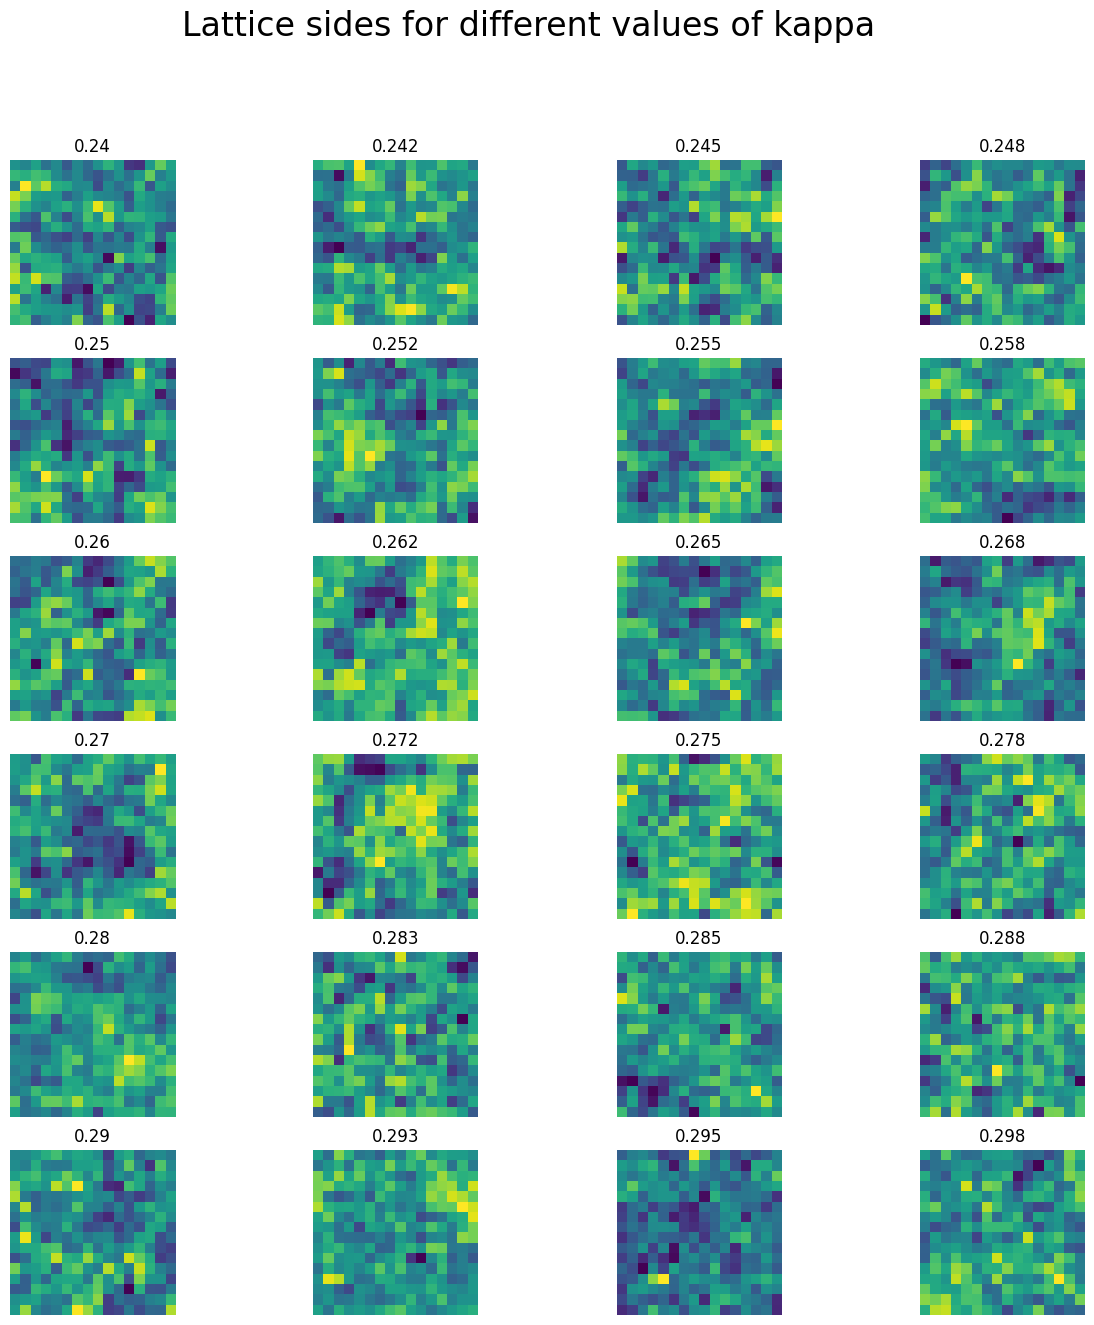

In [3]:
# TODO: Visualize lattice sides for different values of kappa
fig, ax = plt.subplots(6,4, figsize=(15,15))
fig.suptitle('Lattice sides for different values of kappa', fontsize=24)

for i in range(0, len(kappa)):
    #ax[i//4, i%4].imshow(torch.mean(test[i], dim=0))
    ax[i//4, i%4].imshow(test[i,0])
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_title(str(round(kappa[i], 3)))
    
plt.show()

(b)

In [4]:
# TODO: Design a CNN

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32*10*10, 128)
        self.fc2 = nn.Linear(128, 2)

        self.Flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))

        x = self.relu(self.conv2(x))

        x = self.relu(self.conv3(x))

        x = self.Flatten(x)
        x = self.relu(self.fc1(x))

        x = self.softmax(self.fc2(x))
        return x
    
model = CNN()

(c)

In [5]:
# TODO: Train CNN

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

def train_model(model, train_data, train_labels, epochs=10, batch_size=32):
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(train_data), batch_size):
            if i+batch_size > len(train_data):
                batch_size_run = len(train_data) - i
            else:
                batch_size_run = batch_size
            
            batch = train_data[i:i+batch_size_run]
            output = model(batch.unsqueeze(1).float())
            loss = criterion(output, train_labels[i:i+batch_size_run])
            
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            optimizer.zero_grad()
                
        print(f"Epoch {epoch+1}/{epochs}"
              f"Train loss: {np.mean(train_losses):.3f}")

In [6]:
train_model(model, train_data, train_labels)

Epoch 1/10Train loss: 50.420
Epoch 2/10Train loss: 50.408
Epoch 3/10Train loss: 50.404
Epoch 4/10Train loss: 50.403
Epoch 5/10Train loss: 50.401
Epoch 6/10Train loss: 50.401
Epoch 7/10Train loss: 50.400
Epoch 8/10Train loss: 50.400
Epoch 9/10Train loss: 50.399
Epoch 10/10Train loss: 50.399


(d)

In [7]:
# TODO: Evaluate CNN

def evaluate_model(model, test_data, batch_size=32):
    pred = []
    for j in range(test_data.shape[0]):
        x = test_data[j]

        model.eval()
        pred_j = []
        
        with torch.no_grad():
            for i in range(0, x.shape[0], batch_size):
                if i+batch_size > x.shape[0]:
                    batch_size_run = x.shape[0] - i
                else:
                    batch_size_run = batch_size
                
                batch = x[i:i+batch_size_run]
                output = model(batch.unsqueeze(1).float())
                pred_j.append(output.argmax(1))
                
        pred.append(torch.cat(pred_j))
    return pred

pred = evaluate_model(model, test)

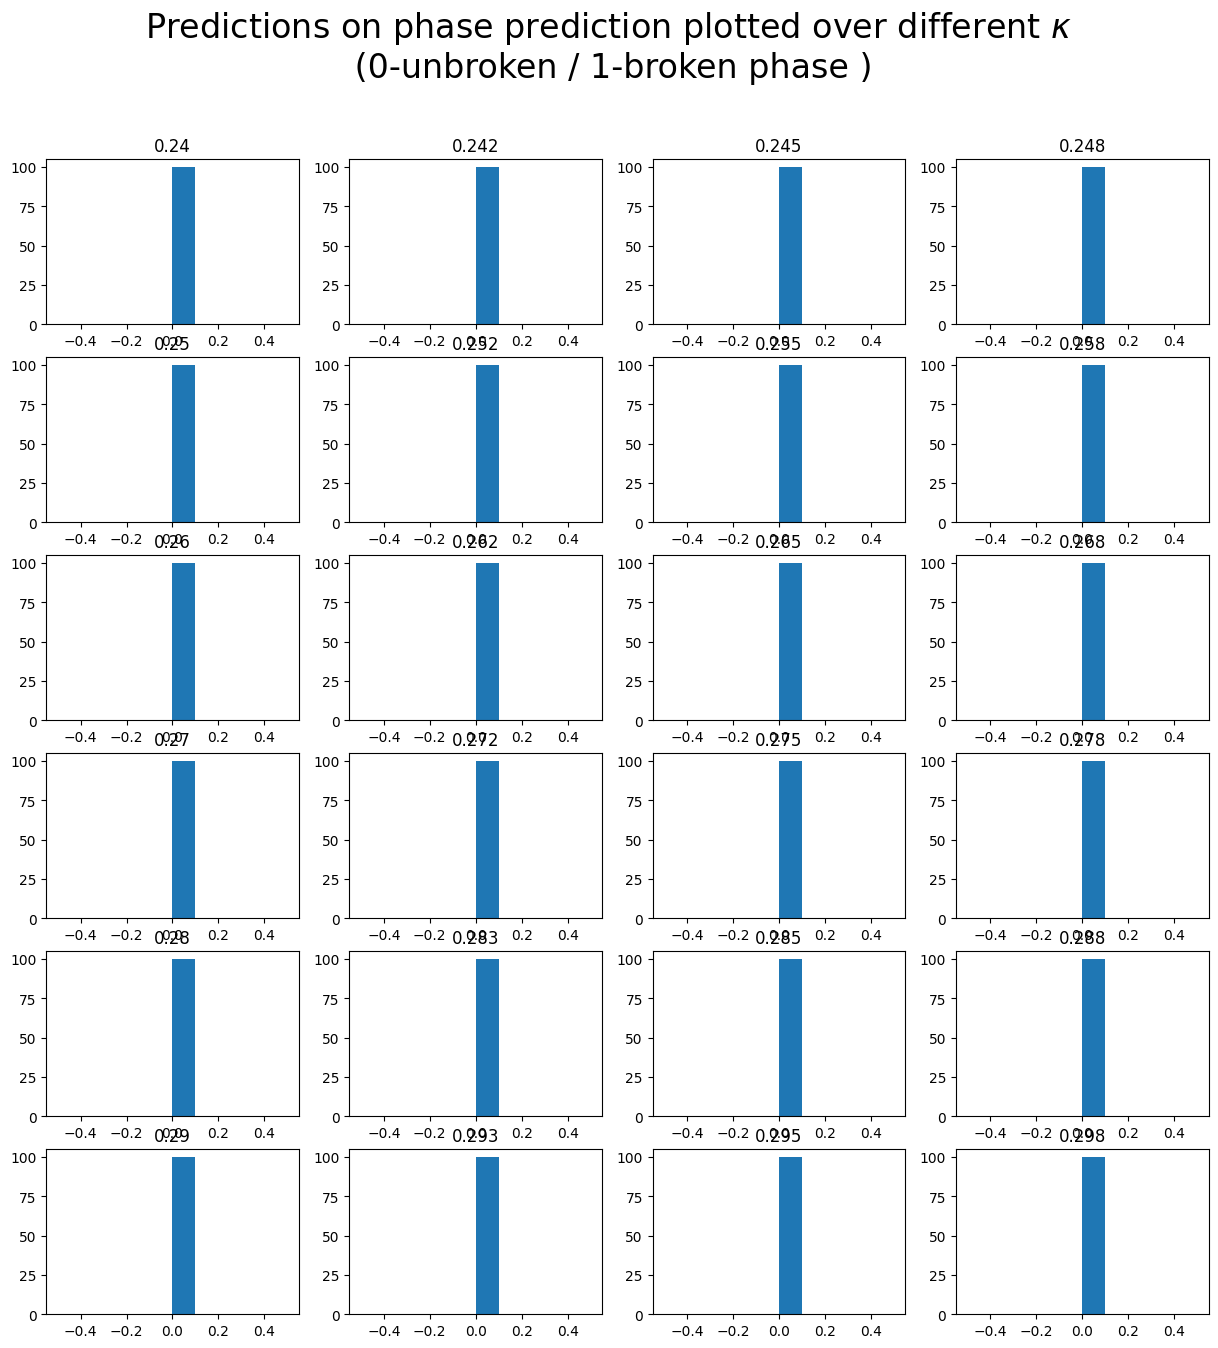

In [8]:
# TODO: Plot means and stds
fig, ax = plt.subplots(6,4, figsize=(15,15))
fig.suptitle('Predictions on phase prediction plotted over different $\kappa$ \n (0-unbroken / 1-broken phase )', fontsize=24)
for i in range(0, len(kappa)):
    ax[i//4, i%4].hist(pred[i].numpy())
    ax[i//4, i%4].set_title(str(round(kappa[i], 3)))
plt.show()    

### the network didnt learn anything
### but i also cant identify the phaseshift in the pictures in a)

# 3) Uncertainties in Amplitude Regression

In [ ]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data04"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "tutorial-2-data.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
%ls
os.chdir("..")

In [ ]:
# load data
trn_dat = np.load("data04/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data04/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data04/tutorial-2-data/val_dat.npy")
val_amp = np.load("data04/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data04/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data04/tutorial-2-data/tst_amp.npy")

print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

(a) 

In [ ]:
# TODO: Recycle code from last sheet

In [ ]:
# TODO: Train ensemble of deterministic networks

In [ ]:
# TODO: Evaluate ensemble -> List of predictions for log A
# result: array preds of shape (10, 30000)

In [ ]:
# uncertainties at event level

preds_means = np.mean(np.log(preds), axis=0)
preds_stds = np.std(np.log(preds), axis=0)

plt.hist(np.log(tst_amp), range=(-20, -8), bins=50, alpha=.5)
plt.hist(preds_means, range=(-20, -8), bins=50, alpha=.5)
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.show()

x = range(len(tst_amp))
plt.fill_between(x, preds_stds, -preds_stds, color="y", label=r"predicted $\sigma_{\log A}$")
plt.plot(x, preds_means - np.log(tst_amp), ",", alpha=.5, ms=.1, label=r"$\log A_\mathrm{pred}-\log A_\mathrm{true}$")
plt.xlabel("# event")
plt.ylim(-1,1)
plt.legend()
plt.show()

# TODO: Interpret results

In [ ]:
# uncertainties at histogram level

hist_test, bins = np.histogram(np.log(tst_amp), range=(-20,-8), bins=50)
hist_data = np.array([np.histogram(np.log(preds[i,:]), bins=bins)[0] for i in range(n_models)])
hist_means = np.mean(hist_data, axis=0)
hist_stds = np.std(hist_data, axis=0)

# means
dup_last = lambda a: np.append(a, a[-1])
plt.step(bins, dup_last(hist_test), label="test")
plt.step(bins, dup_last(hist_means), label="ensemble")
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.legend()
plt.show()

# standard deviations
plt.step(bins, dup_last(np.sqrt(hist_means)), label="statistical uncertainty")
plt.step(bins, dup_last(hist_stds), label="ensemble uncertainty")
plt.xlabel(r"$\log A$")
plt.ylabel("bin standard deviation")
plt.legend()
plt.show()

# means + standard deviations
hists = [hist_test, hist_means]
hist_errors = [np.sqrt(hist_test), hist_stds]
integrals = [np.sum((bins[1:] - bins[:-1])*y) for y in hists]
scales = [1 / integral if integral != 0. else 1. for integral in integrals]

label = ["Test", "ensemble"]
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0.})
for y, y_err, scale, label in zip(hists, hist_errors, scales, label):
    axs[0].step(bins, dup_last(y) * scale, label=label, where="post")
    axs[0].fill_between(bins, dup_last(y + y_err) * scale, 
                     dup_last(y - y_err) * scale, alpha=.5, step="post")
    
    ratio = (y * scale) / (hists[0] * scales[0])
    ratio_err = np.sqrt( (y_err/y)**2 + (hist_errors[0] / hists[0])**2)
    ratio[np.isnan(ratio)] = 1.
    ratio_err[np.isnan(ratio)] = 0.
    
    axs[1].step(bins, dup_last(ratio), where="post")
    axs[1].fill_between(bins, dup_last(ratio + ratio_err), dup_last(ratio - ratio_err), step="post", alpha=.5)
axs[1].set_xlabel(r"$\log A$")
axs[0].set_ylabel("Normalized")
axs[1].set_ylabel(r"$\frac{\mathrm{Ensemble}}{\mathrm{Test}}$")
axs[1].set_ylim(.5, 1.5)
axs[0].legend()
plt.show()

# TODO: Interpret results

(d)

In [ ]:
# TODO: Fill in expression for KL divergence
import math

class VBLinear(nn.Module):
    # VB = variational bayes
    def __init__(self, in_features, out_features, prior_prec=1.0, _map=False, std_init=-5):
        super(VBLinear, self).__init__()
        self.n_in = in_features
        self.n_out = out_features
        self.map = _map
        self.prior_prec = prior_prec # = 1/sigma_prior**2
        self.random = None
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.mu_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.logsig2_w = nn.Parameter(torch.Tensor(out_features, in_features)) # log(sigma_network**2)
        self.std_init = std_init
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(self.std_init, 0.001)
        self.bias.data.zero_()

    def KL(self):
        logsig2_w = self.logsig2_w.clamp(-11, 11)
        kl = None # KL divergence of variational bayes linear layer 
        return kl

    def forward(self, input):
        if self.training:
            # local reparameterization trick is more efficient and leads to
            # an estimate of the gradient with smaller variance.
            # https://arxiv.org/pdf/1506.02557.pdf
            mu_out = nn.functional.linear(input, self.mu_w, self.bias)
            logsig2_w = self.logsig2_w.clamp(-11, 11)
            s2_w = logsig2_w.exp()
            var_out = nn.functional.linear(input.pow(2), s2_w) + 1e-8
            return mu_out + var_out.sqrt() * torch.randn_like(mu_out)

        else:
            if self.map: # just return the mean, no sampling
                return nn.functional.linear(input, self.mu_w, self.bias)

            logsig2_w = self.logsig2_w.clamp(-11, 11)
            if self.random is None:
                self.random = torch.randn_like(self.logsig2_w)
            s2_w = logsig2_w.exp()
            weight = self.mu_w + s2_w.sqrt() * self.random
            return nn.functional.linear(input, weight, self.bias) + 1e-8

In [ ]:
# TODO: Create BNN (like deterministic network, but with bayesian layers)

class bayesian_amp_net(nn.Module):
    
    def __init__(self, training_size, ipt_dim=20, opt_dim=1, hdn_dim=32, n_layers=2):
        pass

    def forward(self, x):
        pass
    
    def KL(self):
        kl = 0
        for layer in self.bayesian_layers:
            kl += layer.KL()
        return kl
    
    def reset_BNN(self):
        for layer in self.bayesian_layers:
            layer.random = None

In [ ]:
def batch_loss_bayesian(model, x, y):
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    kl = model.KL() / trn_dat.shape[0] # correct normalization!
    loss += kl
    return loss

In [ ]:
# TODO: Train BNN

(e)

In [ ]:
# TODO: Evaluate BNN

In [ ]:
# uncertainties at event level

preds_means = np.mean(np.log(preds), axis=0)
preds_stds = np.std(np.log(preds), axis=0)

plt.hist(np.log(tst_amp), range=(-20, -8), bins=50, alpha=.5)
plt.hist(preds_means, range=(-20, -8), bins=50, alpha=.5)
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.show()

x = range(len(tst_amp))
plt.fill_between(x, preds_stds, -preds_stds, color="y", label=r"predicted $\sigma_{\log A}$")
plt.plot(x, preds_means - np.log(tst_amp), ",", alpha=.5, ms=.1, label=r"$\log A_\mathrm{pred}-\log A_\mathrm{true}$")
plt.xlabel("# event")
plt.ylim(-1,1)
plt.legend()
plt.show()

# TODO: Interpret results

In [ ]:
# uncertainties at histogram level

hist_test, bins = np.histogram(np.log(tst_amp), range=(-20,-8), bins=50)
hist_data = np.array([np.histogram(np.log(preds[i,:]), bins=bins)[0] for i in range(n_models)])
hist_means = np.mean(hist_data, axis=0)
hist_stds = np.std(hist_data, axis=0)

# means
dup_last = lambda a: np.append(a, a[-1])
plt.step(bins, dup_last(hist_test), label="test")
plt.step(bins, dup_last(hist_means), label="ensemble")
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.legend()
plt.show()

# standard deviations
plt.step(bins, dup_last(np.sqrt(hist_means)), label="statistical uncertainty")
plt.step(bins, dup_last(hist_stds), label="ensemble uncertainty")
plt.xlabel(r"$\log A$")
plt.ylabel("bin standard deviation")
plt.legend()
plt.show()

# means + standard deviations
hists = [hist_test, hist_means]
hist_errors = [np.sqrt(hist_test), hist_stds]
integrals = [np.sum((bins[1:] - bins[:-1])*y) for y in hists]
scales = [1 / integral if integral != 0. else 1. for integral in integrals]

label = ["Test", "ensemble"]
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0.})
for y, y_err, scale, label in zip(hists, hist_errors, scales, label):
    axs[0].step(bins, dup_last(y) * scale, label=label, where="post")
    axs[0].fill_between(bins, dup_last(y + y_err) * scale, 
                     dup_last(y - y_err) * scale, alpha=.5, step="post")
    
    ratio = (y * scale) / (hists[0] * scales[0])
    ratio_err = np.sqrt( (y_err/y)**2 + (hist_errors[0] / hists[0])**2)
    ratio[np.isnan(ratio)] = 1.
    ratio_err[np.isnan(ratio)] = 0.
    
    axs[1].step(bins, dup_last(ratio), where="post")
    axs[1].fill_between(bins, dup_last(ratio + ratio_err), dup_last(ratio - ratio_err), step="post", alpha=.5)
axs[1].set_xlabel(r"$\log A$")
axs[0].set_ylabel("Normalized")
axs[1].set_ylabel(r"$\frac{\mathrm{Ensemble}}{\mathrm{Test}}$")
axs[1].set_ylim(.5, 1.5)
axs[0].legend()
plt.show()

# TODO: Interpret results